# Chapter 11 - Training Deep Neural Networks

## Problem 1

Is it OK to initialize all the weights to the same value as long as that value is selected randomly using He initialization?

If all weights are initialized with the same value and BackProp via Gradient Descent is used to train a network, then weights will always stay the same. It is highly unlikely that a good solution could be found.

## Problem 2

Is it OK to initialize the bias terms to 0?

Yes, which is also commonly done. The initalization of the bias is not very important.

## Problem 3

Name three advantages of the SELU activation function over ReLU.

1. SELU is continuously differentiable as opposed to ReLU, where the gradient can jump and learning oscillates.
2. SELU does not run the risk of dead nodes.
3. SELU produces on average values closer to zero as it can return negative values. This stabilizes the variance of different layers and helps with vanishing or exploding gradients.

## Problem 4

In which cases would you want to use each of the following activation functions: SELU, leaky ReLU (and its variants), ReLU, tanh, logistic, and softmax?

* tanh, logistic, and softmax are primarily useful for the output layer. tanh if the output range is bounded, logistic for binary classification of bounded ranges, softmax for multiclass classification.
* ReLU is preferrable if prediction speed is critical
* Leaky ReLU allows for learning everywhere, and prevents dead nodes, and is faster than SELU.
* SELU tends to perform best, but requires more compute

## Problem 5

What may happen if you set the momentum hyperparameter too close to 1 (e.g., 0.99999) when using an SGD optimizer?

When momentum is very high, the step direction is updated very slowly. This risks that the parameter search overshoots and takes a long time to correct itself.

## Problem 6

Name three ways you can produce a sparse model.

1. L1 regularization
2. Pruning, i.e. set sufficiently small weights to zero.
3. Use the TensorFlow Model Optimization Toolkit

## Problem 7

Does dropout slow down training? Does it slow down inference (i.e., making predictions on new instances)? What about MC Dropout?

1. Yes, dropout slows down training - in general - as in each training step any given node may or may not learn
2. Dropout does not slow down inference, as all nodes are always included.
3. MC Dropout slows down inference, as multiple predictions need to be made.

## Problem 8

Practice training a deep neural network on the CIFAR10 image dataset:

In [62]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=5000)

### Problem 8a

Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the ELU activation function.

In [4]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=X_train.shape[1:]))
for i in range(20):
    model.add(keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'))

### Problem 8b

Using Nadam optimization and early stopping, train the network on the
CIFAR10 dataset. You can load it with keras.datasets.cifar10.load_
data() . The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you’ll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model’s architecture or hyperparameters.

In [5]:
model.add(keras.layers.Dense(10, activation='softmax'))

In [8]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)

In [9]:
%load_ext tensorboard

In [10]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

In [11]:
index_run = 0
Wsave = model.get_weights()
for lr in range(4,11):
    lr = 10**(-lr/2)
    index_run += 1
    run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(index_run))
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
    callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
    optimizer = keras.optimizers.Nadam(lr=lr)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model.fit(X_train, y_train, epochs=25, validation_data=(X_valid, y_valid), callbacks=callbacks)
    model.set_weights(Wsave)

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 14s 310us/sample - loss: 13.8890 - accuracy: 0.1843 - val_loss: 2.0346 - val_accuracy: 0.2118
Epoch 2/25
45000/45000 [==============================] - 11s 243us/sample - loss: 469092825.2416 - accuracy: 0.1806 - val_loss: 2.3073 - val_accuracy: 0.0936
Epoch 3/25
45000/45000 [==============================] - 11s 246us/sample - loss: 2.3054 - accuracy: 0.1004 - val_loss: 2.3027 - val_accuracy: 0.1012
Epoch 4/25
45000/45000 [==============================] - 11s 252us/sample - loss: 2.3062 - accuracy: 0.1000 - val_loss: 2.3119 - val_accuracy: 0.0958
Epoch 5/25
45000/45000 [==============================] - 11s 253us/sample - loss: 2.3066 - accuracy: 0.0992 - val_loss: 2.3127 - val_accuracy: 0.0936
Epoch 6/25
45000/45000 [==============================] - 11s 237us/sample - loss: 2.3074 - accuracy: 0.1002 - val_loss: 2.3131 - val_accuracy: 0.1062
Epoch 7/25
45000/45000 [============

In [21]:
best_lr = 10**(-8/2)

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=X_train.shape[1:]))
for i in range(20):
    model.add(keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'))
model.add(keras.layers.Dense(10, activation="softmax"))

In [24]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)

In [25]:
lr = best_lr
index_run += 1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(index_run))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
optimizer = keras.optimizers.Nadam(lr=lr)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [26]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 12s 265us/sample - loss: 3.3934 - accuracy: 0.1833 - val_loss: 2.1382 - val_accuracy: 0.2414
Epoch 2/100
45000/45000 [==============================] - 10s 219us/sample - loss: 1.9744 - accuracy: 0.2704 - val_loss: 1.9653 - val_accuracy: 0.2812
Epoch 3/100
45000/45000 [==============================] - 10s 220us/sample - loss: 1.8706 - accuracy: 0.3119 - val_loss: 1.8616 - val_accuracy: 0.3120
Epoch 4/100
45000/45000 [==============================] - 10s 230us/sample - loss: 1.8000 - accuracy: 0.3421 - val_loss: 1.8221 - val_accuracy: 0.3420
Epoch 5/100
45000/45000 [==============================] - 10s 215us/sample - loss: 1.7418 - accuracy: 0.3676 - val_loss: 1.7353 - val_accuracy: 0.3834
Epoch 6/100
45000/45000 [==============================] - 10s 213us/sample - loss: 1.6920 - accuracy: 0.3847 - val_loss: 1.6922 - val_accuracy: 0.3894
Epoch 7/100
45000/45000 [==============

In [28]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

5000/5000 [==============================] - 0s 71us/sample - loss: 1.4946 - accuracy: 0.4866


[1.4945957498550415, 0.4866]

### Problem 8c

Now try adding Batch Normalization and compare the learning curves: Is it
converging faster than before? Does it produce a better model? How does it affect training speed?

In [29]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [30]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=X_train.shape[1:]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [31]:
optimizer = keras.optimizers.Nadam(lr=best_lr)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [32]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
index_run += 1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(index_run))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [33]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 25s 554us/sample - loss: 1.9263 - accuracy: 0.3115 - val_loss: 1.6841 - val_accuracy: 0.4020
Epoch 2/100
45000/45000 [==============================] - 20s 438us/sample - loss: 1.7041 - accuracy: 0.3916 - val_loss: 1.5915 - val_accuracy: 0.4434
Epoch 3/100
45000/45000 [==============================] - 20s 439us/sample - loss: 1.6298 - accuracy: 0.4197 - val_loss: 1.5677 - val_accuracy: 0.4442
Epoch 4/100
45000/45000 [==============================] - 20s 442us/sample - loss: 1.5755 - accuracy: 0.4404 - val_loss: 1.5076 - val_accuracy: 0.4728
Epoch 5/100
45000/45000 [==============================] - 20s 443us/sample - loss: 1.5334 - accuracy: 0.4529 - val_loss: 1.4973 - val_accuracy: 0.4808
Epoch 6/100
45000/45000 [==============================] - 20s 449us/sample - loss: 1.4974 - accuracy: 0.4673 - val_loss: 1.4630 - val_accuracy: 0.4860
Epoch 7/100
45000/45000 [==============

In [34]:
model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

5000/5000 [==============================] - 1s 143us/sample - loss: 1.3619 - accuracy: 0.5352


[1.3619005823135375, 0.5352]

### Problem 8d

Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).

In [35]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [36]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=X_train.shape[1:]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [37]:
optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [38]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
index_run += 1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(index_run))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [43]:
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [44]:
model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 11s 248us/sample - loss: 1.8895 - accuracy: 0.3271 - val_loss: 1.8037 - val_accuracy: 0.3632
Epoch 2/100
45000/45000 [==============================] - 10s 227us/sample - loss: 1.6749 - accuracy: 0.4074 - val_loss: 1.6456 - val_accuracy: 0.4284
Epoch 3/100
45000/45000 [==============================] - 10s 223us/sample - loss: 1.5706 - accuracy: 0.4462 - val_loss: 1.6278 - val_accuracy: 0.4344
Epoch 4/100
45000/45000 [==============================] - 11s 234us/sample - loss: 1.5047 - accuracy: 0.4719 - val_loss: 1.5909 - val_accuracy: 0.4450
Epoch 5/100
45000/45000 [==============================] - 10s 220us/sample - loss: 1.4467 - accuracy: 0.4943 - val_loss: 1.5748 - val_accuracy: 0.4582
Epoch 6/100
45000/45000 [==============================] - 10s 225us/sample - loss: 1.3964 - accuracy: 0.5100 - val_loss: 1.5154 - val_accuracy: 0.4842
Epoch 7/100
45000/45000 [==============

In [45]:
model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

5000/5000 [==============================] - 0s 75us/sample - loss: 1.4792 - accuracy: 0.4870


[1.4791791608810425, 0.487]

### Problem 8e

Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.

In [46]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [47]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=X_train.shape[1:]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

In [48]:
optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [49]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
index_run += 1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(index_run))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [50]:
model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 11s 239us/sample - loss: 1.8948 - accuracy: 0.3245 - val_loss: 1.7993 - val_accuracy: 0.3766
Epoch 2/100
45000/45000 [==============================] - 10s 212us/sample - loss: 1.6708 - accuracy: 0.4102 - val_loss: 1.6708 - val_accuracy: 0.4296
Epoch 3/100
45000/45000 [==============================] - 10s 230us/sample - loss: 1.5791 - accuracy: 0.4405 - val_loss: 1.6373 - val_accuracy: 0.4394
Epoch 4/100
45000/45000 [==============================] - 10s 212us/sample - loss: 1.5106 - accuracy: 0.4723 - val_loss: 1.6435 - val_accuracy: 0.4402
Epoch 5/100
45000/45000 [==============================] - 10s 217us/sample - loss: 1.4588 - accuracy: 0.4904 - val_loss: 1.5911 - val_accuracy: 0.4814
Epoch 6/100
45000/45000 [==============================] - 10s 233us/sample - loss: 1.4054 - accuracy: 0.5087 - val_loss: 1.5313 - val_accuracy: 0.4762
Epoch 7/100
45000/45000 [==============

In [51]:
model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

5000/5000 [==============================] - 0s 79us/sample - loss: 1.5064 - accuracy: 0.4958


[1.5063763664245606, 0.4958]

In [52]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [53]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [54]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

In [55]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.4988

### Problem 8f

Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.

In [56]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [57]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=X_train.shape[1:]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

In [58]:
optimizer = keras.optimizers.SGD(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [59]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

Train on 45000 samples
45000/45000 [==============================] - 1s 32us/sample - loss: nan - accuracy: 0.1390


[1e-05, 9.999868, 2.0207415, 3.5734329904828757]

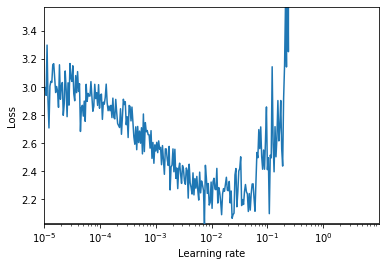

In [63]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [64]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [65]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=X_train.shape[1:]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

In [66]:
optimizer = keras.optimizers.SGD(lr=best_lr)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [68]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [69]:
n_epochs = 50
onecycle = OneCycleScheduler(len(X_train_scaled) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 2s 40us/sample - loss: 2.0565 - accuracy: 0.2812 - val_loss: 1.7915 - val_accuracy: 0.3670
Epoch 2/50
45000/45000 [==============================] - 1s 29us/sample - loss: 1.7969 - accuracy: 0.3672 - val_loss: 1.7063 - val_accuracy: 0.4140
Epoch 3/50
45000/45000 [==============================] - 1s 29us/sample - loss: 1.6658 - accuracy: 0.4100 - val_loss: 1.6782 - val_accuracy: 0.4264
Epoch 4/50
45000/45000 [==============================] - 1s 29us/sample - loss: 1.5736 - accuracy: 0.4419 - val_loss: 1.6218 - val_accuracy: 0.4374
Epoch 5/50
45000/45000 [==============================] - 1s 28us/sample - loss: 1.5085 - accuracy: 0.4650 - val_loss: 1.6376 - val_accuracy: 0.4468
Epoch 6/50
45000/45000 [==============================] - 1s 29us/sample - loss: 1.4545 - accuracy: 0.4797 - val_loss: 1.5893 - val_accuracy: 0.4544
Epoch 7/50
45000/45000 [==============================] -